In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
workers = 4
ngpu = 1
beta1 = 0.5
lr = 0.0002
bs = 8
epochs = 20

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 12, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(12, 4, kernel_size = 3, padding = 1)

        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.sigmoid(self.conv3(xb))       

        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model_1 = SuperResolution().to(device)
    model_2 = SuperResolution().to(device)
    model_3 = SuperResolution().to(device)
    
    return model_1, model_2, model_3, optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9), optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9), optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func, i):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
        self.channel = i
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x[:,self.channel].unsqueeze(1), b_y[:,self.channel].unsqueeze(1)))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl_1 = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess, 0)
valid_dl_1 = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess, 0)

train_dl_2 = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess, 1)
valid_dl_2 = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess, 1)

train_dl_3 = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess, 2)
valid_dl_3 = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess, 2)

val_losses_1 = []
val_losses_2 = []
val_losses_3 = []

model_1, model_2, model_3, opt_1, opt_2, opt_3 = get_model()
fit(epochs, model_1, loss_func, opt_1, train_dl_1, valid_dl_1, val_losses_1)
fit(epochs, model_2, loss_func, opt_2, train_dl_2, valid_dl_2, val_losses_2)
fit(epochs, model_3, loss_func, opt_3, train_dl_3, valid_dl_3, val_losses_3)

0 0.2155293639500936
1 0.21399840772151946
2 0.21315846006075542
3 0.21245895346005758
4 0.21185475707054138
5 0.2113214800755183
6 0.21084113617738087
7 0.21040090084075927
8 0.2099921751022339
9 0.2096094963947932
10 0.2092496959368388
11 0.2089110710223516
12 0.20859274645646414
13 0.20829417208830517
14 0.20801466822624207
15 0.20775332709153493
16 0.20750895102818806
17 0.20728012839953106
18 0.2070654074350993
19 0.2068633496761322
0 0.20303739507993063
1 0.20130816578865052
2 0.2003679879506429
3 0.1995882205168406
4 0.19890540957450867
5 0.19829618175824484
6 0.19774654269218445
7 0.19724830150604247
8 0.1967971960703532
9 0.1963907837867737
10 0.19602679173151652
11 0.19570223848025003
12 0.19541319052378336
13 0.19515515764554342
14 0.19492350061734517
15 0.19471380909283956
16 0.194522176583608
17 0.19434529344240825
18 0.19418043653170267
19 0.19402544617652892
0 0.25486315886179606
1 0.2538075983524323
2 0.25306976795196534
3 0.25242235223452253
4 0.2518487628300985
5 0.25

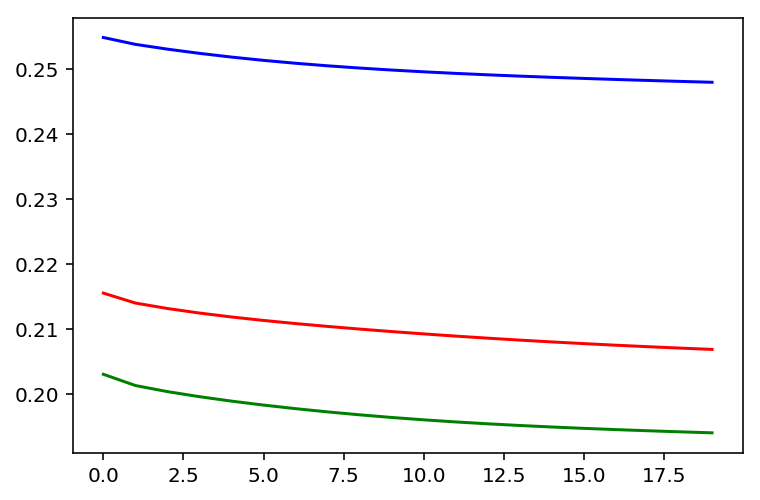

In [14]:
plt.plot(val_losses_1, color = "red")
plt.plot(val_losses_2, color = "green")
plt.plot(val_losses_3, color = "blue")
plt.show()

In [15]:
torch.save(model_1, "SR_model_1_1.0.ml")
torch.save(model_2, "SR_model_2_1.0.ml")
torch.save(model_3, "SR_model_3_1.0.ml")

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SuperResolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>